<a href="https://colab.research.google.com/github/jaynarayan94/All-my-Blog-codes-and-datasets/blob/master/Predict%20if%20a%20Customer%20will%20Purchase%20on%20a%20website%20or%20not%3F/Online_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Importing the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression ,LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,RobustScaler,LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score

# !pip install xgboost

from collections import Counter
from sklearn.utils import resample

from IPython.display import display
pd.set_option('display.max_columns', 60)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

plt.style.use('fivethirtyeight')

import random
random.seed(9001)

## Reading & Preprocess the data

In [22]:
data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')
df = data.copy()
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [23]:
pd.DataFrame({'Count_Missing' : df.isnull().sum(), 'Perc_Missing' : 100*df.isnull().sum()/len(df)}).sort_values(by = ['Count_Missing'], ascending=False).head(12)

,Count_Missing,Perc_Missing
Administrative,0,0.0
Administrative_Duration,0,0.0
Weekend,0,0.0
VisitorType,0,0.0
TrafficType,0,0.0
Region,0,0.0
Browser,0,0.0
OperatingSystems,0,0.0
Month,0,0.0
SpecialDay,0,0.0


In [24]:
[Counter(df['VisitorType'])]

[Counter({'New_Visitor': 1694, 'Other': 85, 'Returning_Visitor': 10551})]

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [26]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Administrative,12330.0,2.315166,3.321784,0.0,0.000000,1.000000,4.000000,27.000000
Administrative_Duration,12330.0,80.818611,176.779107,0.0,0.000000,7.500000,93.256250,3398.750000
Informational,12330.0,0.503569,1.270156,0.0,0.000000,0.000000,0.000000,24.000000
Informational_Duration,12330.0,34.472398,140.749294,0.0,0.000000,0.000000,0.000000,2549.375000
ProductRelated,12330.0,31.731468,44.475503,0.0,7.000000,18.000000,38.000000,705.000000
ProductRelated_Duration,12330.0,1194.746220,1913.669288,0.0,184.137500,598.936905,1464.157213,63973.522230
BounceRates,12330.0,0.022191,0.048488,0.0,0.000000,0.003112,0.016813,0.200000
ExitRates,12330.0,0.043073,0.048597,0.0,0.014286,0.025156,0.050000,0.200000
PageValues,12330.0,5.889258,18.568437,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12330.0,0.061427,0.198917,0.0,0.000000,0.000000,0.000000,1.000000


Counter({False: 10422, True: 1908})


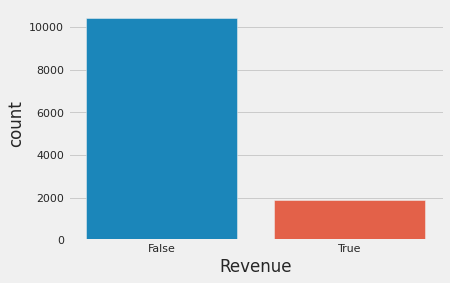

In [27]:
print(Counter(df['Revenue']))

sns.countplot(df['Revenue']);

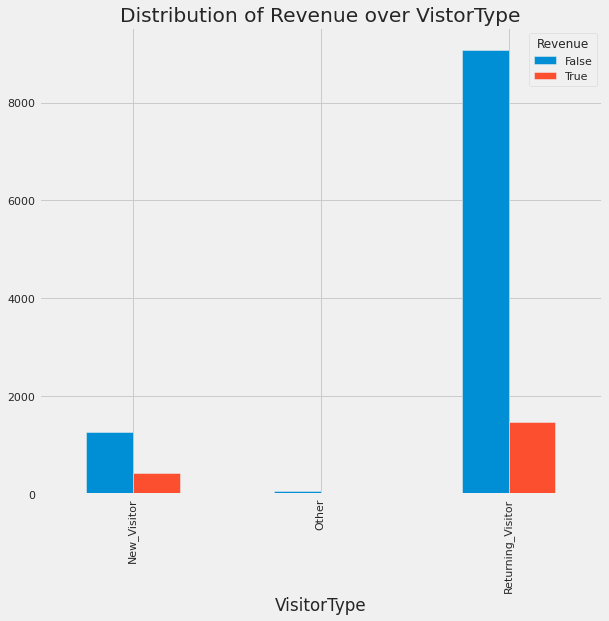

In [28]:
pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind='bar',figsize=(9,8),title="Distribution of Revenue over VistorType")

plt.show();

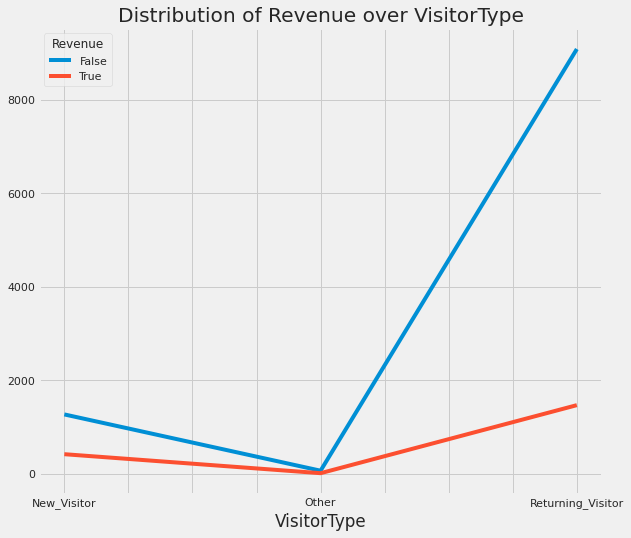

In [29]:
pd.crosstab(df['VisitorType'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribution of Revenue over VisitorType")

plt.show();

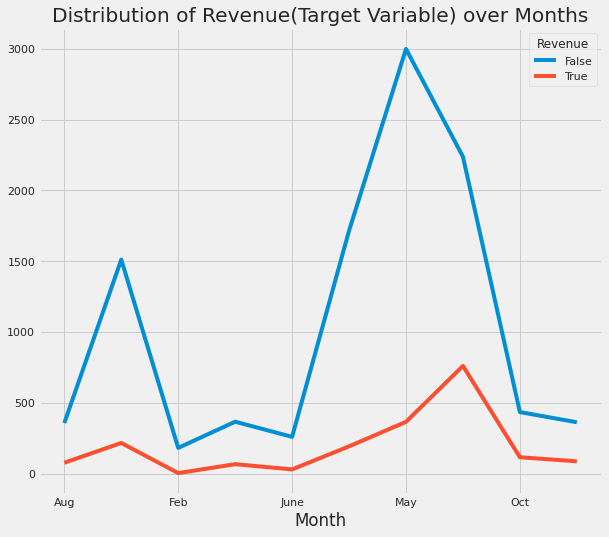

In [30]:
df = df.sort_values('Month')

pd.crosstab(df['Month'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribution of Revenue(Target Variable) over Months")

plt.show();

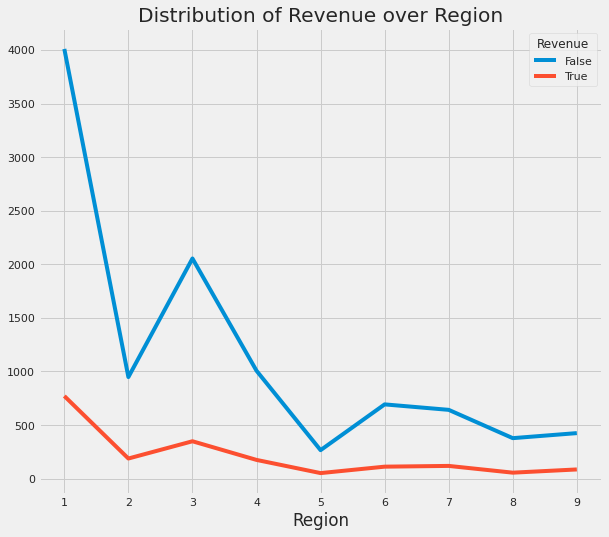

In [31]:
pd.crosstab(df['Region'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribution of Revenue over Region")

plt.show();

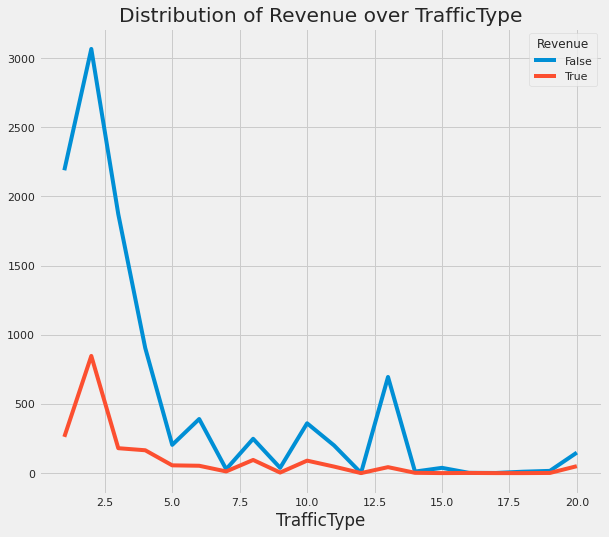

In [32]:
pd.crosstab(df['TrafficType'],df['Revenue']).plot(kind='line',figsize=(9,8),title="Distribution of Revenue over TrafficType")

plt.show();

In [33]:
df = pd.get_dummies( df, columns = ['VisitorType','Month'])

df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType,Weekend,Revenue,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor,Month_Aug,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep
7427,0,0.000000,0,0.0,75,2532.960656,0.004267,0.030749,0.000000,0.0,1,6,1,1,False,False,0,0,1,1,0,0,0,0,0,0,0,0,0
7031,0,0.000000,0,0.0,18,345.120000,0.044444,0.072222,0.000000,0.0,2,2,3,13,False,False,0,0,1,1,0,0,0,0,0,0,0,0,0
7036,13,345.016667,0,0.0,90,1816.555008,0.000000,0.004861,86.310343,0.0,4,2,3,4,False,False,0,0,1,1,0,0,0,0,0,0,0,0,0
7665,0,0.000000,0,0.0,2,11.000000,0.000000,0.100000,0.000000,0.0,3,2,1,4,False,False,0,0,1,1,0,0,0,0,0,0,0,0,0
7039,11,373.620000,9,322.8,191,3677.258176,0.009106,0.024304,0.000000,0.0,2,2,6,1,True,False,0,0,1,1,0,0,0,0,0,0,0,0,0


In [0]:
df['Weekend'] = df['Weekend'].astype(int)
df['Revenue'] = df['Revenue'].astype(int)

In [0]:
X = df.drop('Revenue', axis=1)
Y = df['Revenue']

# # Histogram of all features
# for idx,column in enumerate(X.columns): 
#     plt.figure(idx)
#     X.hist(column=column,grid=False);

## Checking for Collinearity between features

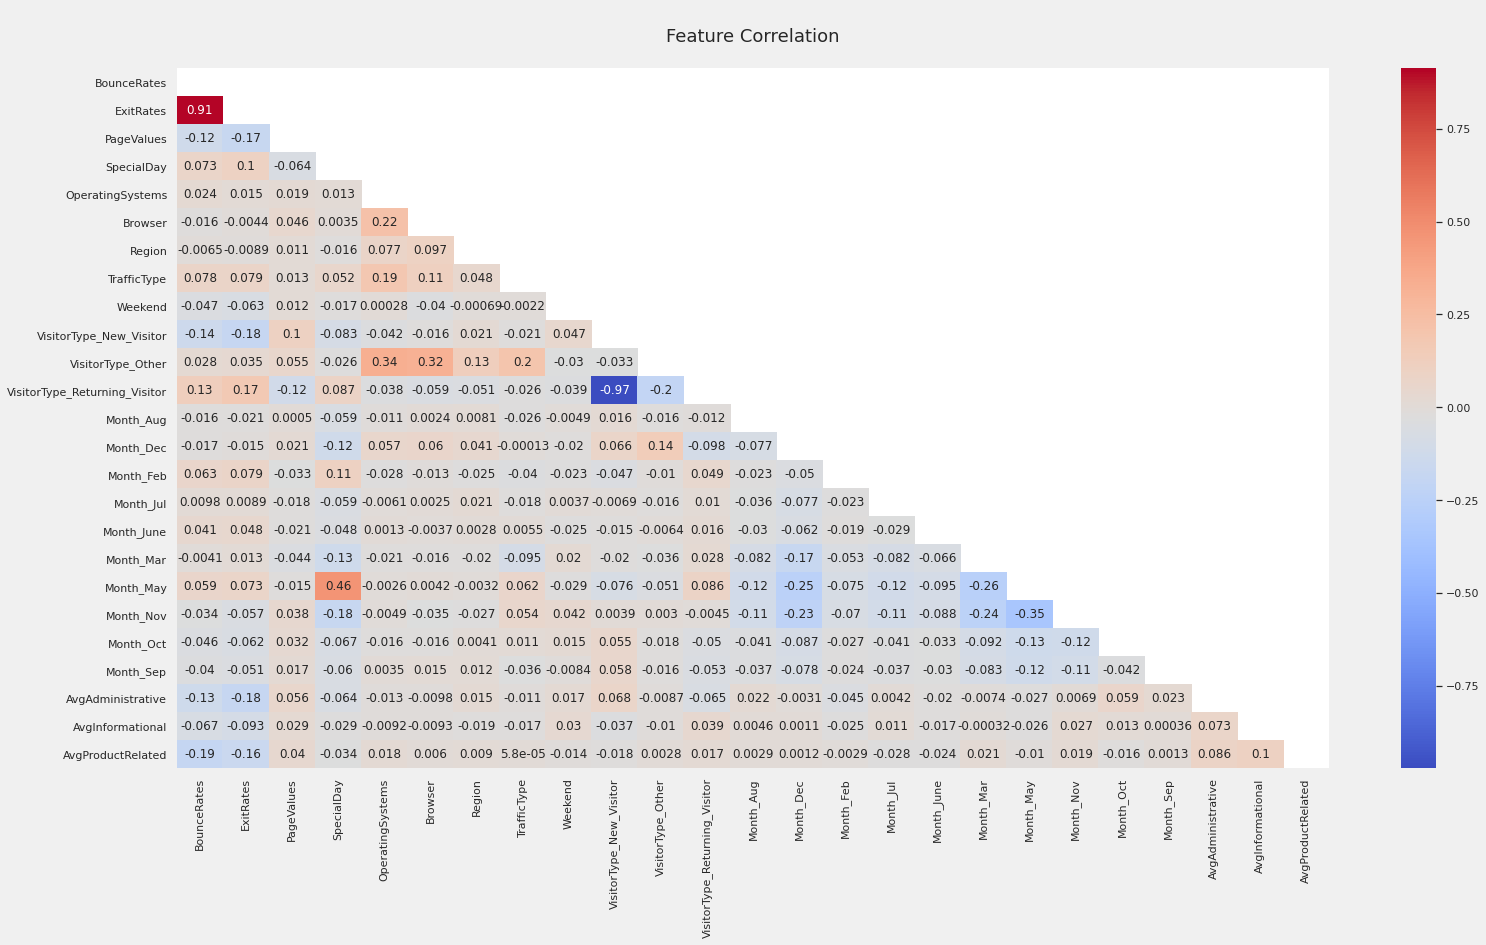

In [36]:
def AvgMinutes(Count, Duration):
    """Calculate the Avg Munutes for the specific columns"""
    if Duration == 0:
        output = 0
    elif Duration != 0:
        output = float(Duration)/float(Count)
    return output
    
Columns = [['Administrative', 'Administrative_Duration'], 
           ['Informational', 'Informational_Duration'], 
           ['ProductRelated', 'ProductRelated_Duration']]
    
    
X['AvgAdministrative'] = X.apply(lambda x: AvgMinutes(Count = x['Administrative'], Duration = x['Administrative_Duration']), axis = 1)
X['AvgInformational'] = X.apply(lambda x: AvgMinutes(Count = x['Informational'], Duration = x['Informational_Duration']), axis = 1)
X['AvgProductRelated'] = X.apply(lambda x: AvgMinutes(Count = x['ProductRelated'], Duration = x['ProductRelated_Duration']), axis = 1)
X.drop(['Administrative', 'Administrative_Duration','Informational', 
        'Informational_Duration','ProductRelated', 'ProductRelated_Duration'],axis = 1, inplace = True)


def half_masked_corr_heatmap(X,title=None, file=None):
    """Plots the Half masked Pearson Correlation Graph"""
    plt.figure(figsize=(23,12))
    sns.set(font_scale=1)
    
    mask = np.zeros_like(X.corr())
    mask[np.triu_indices_from(mask)] = True
    
    with sns.axes_style('white'):
        sns.heatmap(X.corr(), mask = mask, annot =True, cmap='coolwarm')
        
    if title: plt.title(f'\n{title}\n',fontsize=18)
    plt.xlabel('')
    plt.ylabel('')
    if file: plt.savefig(file,bbox_inches='tight')
    plt.show()
    
    return

half_masked_corr_heatmap(X,"Feature Correlation")

In [0]:
# for i in X.columns:
#     print('####################')
#     print('COLUMN TITLE:',i)
#     print('# UNIQUE VALUES:',len(X[i].unique()))
#     print('UNIQUE VALUES:',X[i].unique())
#     print('####################')
#     print()

In [0]:
# # Scaling to normalize data
# X_copy = X.copy()
# rc = RobustScaler()
# X_rc=rc.fit_transform(X_copy)
# X_rc=pd.DataFrame(X_rc,columns=X.columns)

# for idx,column in enumerate(X_rc.columns):
#     plt.figure(idx)
#     X_rc.hist(column=column,grid=False);

## Linear Model with All Features

In [39]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2)

print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

features = df.columns[:-1]

(9864, 25) (2466, 25)
(9864,) (2466,)


In [0]:
result_dict = {}
# Helper function to summarize
def summarize_classification(y_test,y_pred):
    """
    As it's take the actual target labels of the test set and predicted label.
    and will Give the summary of the Goodness of fit of the mode on the Validation/test dataset.
    """
    acc = accuracy_score(y_test,y_pred,normalize=True)
    num_acc = accuracy_score(y_test,y_pred,normalize=False)
    
    prec = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)
    F1_score =  f1_score(y_test,y_pred)
    auc_score = roc_auc_score(y_test,y_pred)
    
    
    return{'Accuracy:': acc,
           'Accuracy_count:': num_acc,
           'Precision:': prec,
           'Recall:': recall,
           'F1_score:':F1_score,
           'AUC_ROC:':auc_score}


In [0]:
# Helper function to Build Model
def build_model(classifier_fn,
                name_of_y_col,
                name_of_x_cols,
                dataset,test_frac=0.2,
                show_plot_auc=None):
  
    """
    Builds end to end model and share the model summary.
    if show_plot_auc==True : Plot the AUC - ROC curve.
    """ 
    
    # Separating the  input features (X) and target variable (y)
    X = df.drop('Revenue', axis=1)
    Y = df['Revenue']
    
    # feature Scaling
    scale_x = StandardScaler()
    x = scale_x.fit_transform(X)
    
    x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2,random_state=0)
    
    model = classifier_fn(x_train,y_train)
    
    y_pred = model.predict(x_test)
    
    y_pred_train = model.predict(x_train)
    
    train_summary = summarize_classification(y_train,y_pred_train)
    test_summary = summarize_classification(y_test,y_pred)
    
    pred_result = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
    
    model_crosstab = pd.crosstab(pred_result.y_pred,pred_result.y_test)
    
    if show_plot_auc==True:
        plt.figure(figsize=(8,6))
        
        logit_roc_auc1 = roc_auc_score(y_train, model.predict(x_train))
        fpr1, tpr1, thresholds1 = roc_curve(y_train, model.predict_proba(x_train)[:,1])
        plt.plot(fpr1, tpr1, label='Class_Train (AUC = %0.2f)' % logit_roc_auc1)
            
        logit_roc_auc2 = roc_auc_score(y_test, model.predict(x_test))
        fpr2, tpr2, thresholds2 = roc_curve(y_test, model.predict_proba(x_test)[:,1])
        plt.plot(fpr2, tpr2,label='Class_Test (AUC = %0.2f)' % logit_roc_auc2)
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic(ROC-AUC)')
        plt.legend(loc="lower right")
        plt.show()
        
    
    return{'training':train_summary,
          'test':test_summary,
          'confusion_matrix':model_crosstab
          }

In [0]:
# Helper function to compare the score of different Model.    
def compare_result():
    """
    Shows Train the Test data summary for the all the Model runned in form of data dictionary.
    """
    for key in result_dict:
        print('Classification: ',key)
        
        print()
        print('Training data:-')
        for score in result_dict[key]['training']:
            print(score,result_dict[key]['training'][score])
            
        print()
        print('Test Data:-')
        for score in result_dict[key]['test']:
            print(score,result_dict[key]['test'][score])
            
        print()

## Model 1 : Logistic Regression

In [0]:
def logistic_fn(x_train,y_train):
    """
    Function to buld logistic Model for the given dataset
    """
    model = LogisticRegression(solver='liblinear',random_state=12)
    model.fit(x_train,y_train)
    
    return model

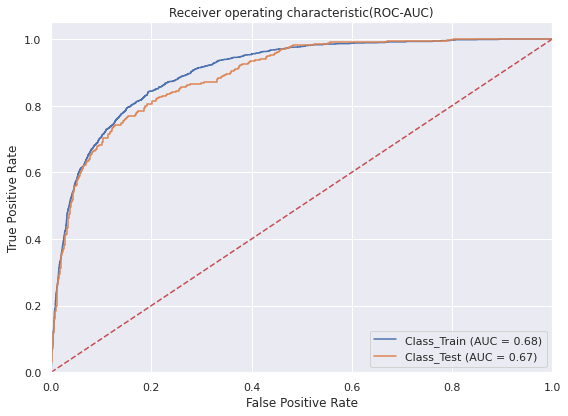

In [44]:
result_dict['Revenue ~ Logistic'] = \
    build_model(logistic_fn,'Revenue',features,df,show_plot_auc=True)

In [45]:
compare_result()

Classification:  Revenue ~ Logistic

Training data:-
Accuracy: 0.8849351175993512
Accuracy_count: 8729
Precision: 0.7484116899618806
Recall: 0.3859764089121887
F1_score: 0.5092952875054042
AUC_ROC: 0.6811148535326115

Test Data:-
Accuracy: 0.8815896188158961
Accuracy_count: 2174
Precision: 0.7368421052631579
Recall: 0.36649214659685864
F1_score: 0.48951048951048953
AUC_ROC: 0.6712499120700225



In [0]:
def logistic_CV_fn(x_train,y_train):
    """
    Function to buld logistic Model using the Cross Validation of 10 folds for the given dataset
    """
    model = LogisticRegressionCV(cv=10,random_state=12,solver='liblinear')
    model.fit(x_train,y_train)
    
    return model

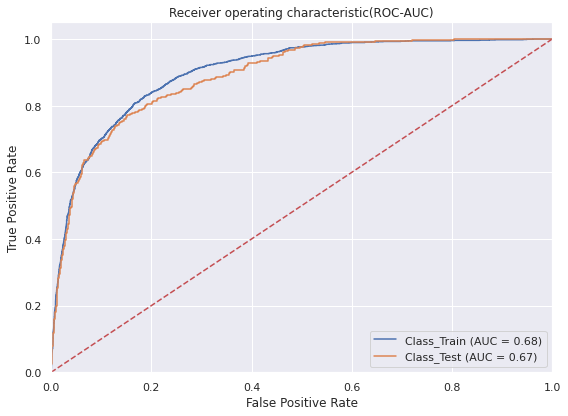

In [47]:
result_dict['Revenue ~ Logistic_CV'] = build_model(logistic_CV_fn,'Revenue',features,df,show_plot_auc=True)

## Model 2 : K-Nearest Neighbors (KNN)

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Value of k for KNN')

Text(0, 0.5, 'Cross-Validated Accuracy')

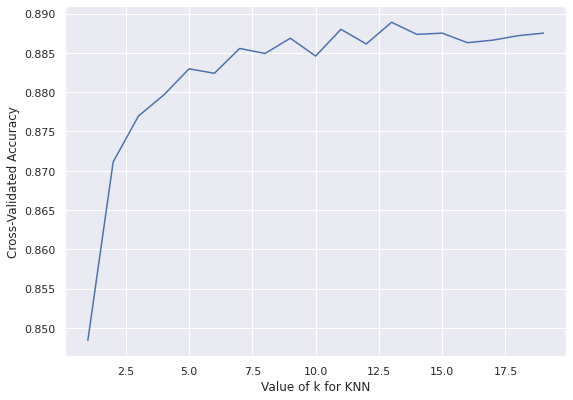

[(1, 0.8484184914841849),
 (2, 0.8711273317112733),
 (3, 0.8769667477696675),
 (4, 0.8796431467964314),
 (5, 0.8829683698296836),
 (6, 0.8824006488240066),
 (7, 0.8855636658556367),
 (8, 0.8849148418491483),
 (9, 0.8868613138686131),
 (10, 0.8845904298459042),
 (11, 0.8879967558799675),
 (12, 0.8861313868613138),
 (13, 0.8888888888888887),
 (14, 0.8873479318734795),
 (15, 0.8875101378751014),
 (16, 0.8862935928629361),
 (17, 0.8866180048661801),
 (18, 0.8871857258718574),
 (19, 0.8875101378751014)]

In [48]:
# Plot to check best value for k to chose based on the accuracy score
k_range = range(1, 20)
k_scores = []
# use iteration to caclulator different k in models, then return the average accuracy based on the cross validation
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, Y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly
plt.figure(figsize=(8,6))
plt.plot(k_range, k_scores)
plt.xlabel('Value of k for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show();

list(enumerate(k_scores,1))

In [0]:
def knn_fn(x_train,y_train,n_neighbors=9,random_state=12):
    """
    Function to buld KNN Model for the given dataset
    """
    
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(x_train,y_train)
    
    return model

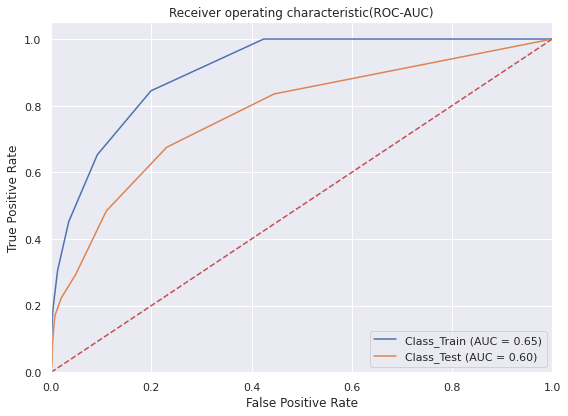

In [50]:
result_dict['Revenue ~ KNN'] = \
    build_model(knn_fn,'Revenue',features,df,show_plot_auc=True)

## Model 3 : Naive Bayes Classifier

In [0]:
def naive_bayes_fn(x_train,y_train,priors=None):
    """
    Function to buld Naive Bayes Model for the given dataset
    """
    
    model = GaussianNB(priors=priors)
    model.fit(x_train,y_train)
    
    return model

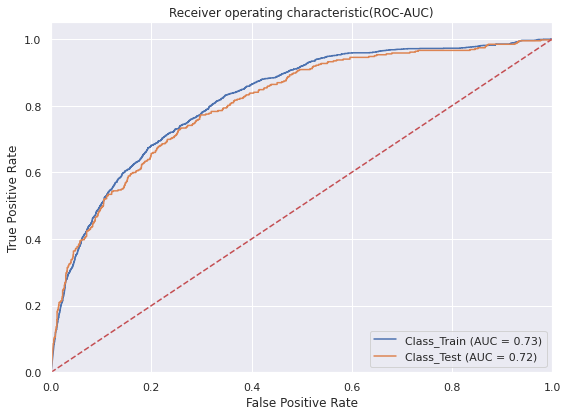

In [52]:
result_dict['Revenue ~ Naive_Bayes'] = \
    build_model(naive_bayes_fn,'Revenue',features,df,show_plot_auc=True)

## Model 4 : Random Forest Classifier

In [0]:
def random_forest_fn(x_train,y_train):
    """
    Function to buld ensemble model using 50 decision trees for the given dataset
    """
    model = RandomForestClassifier(n_estimators= 50, max_depth = 15,random_state=12 )
    model.fit(x_train,y_train)
    
    return model

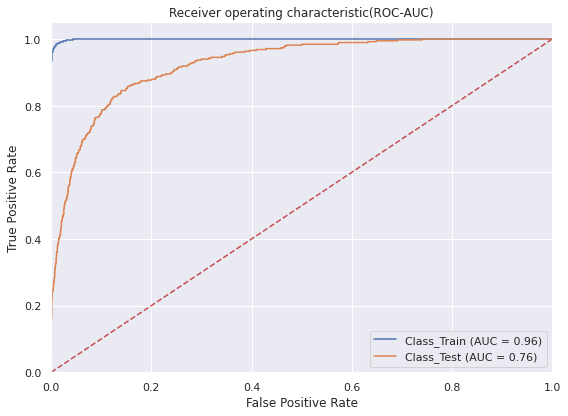

In [54]:
result_dict['Revenue ~ Random_Forest'] = \
    build_model(random_forest_fn,'Revenue',features,df,show_plot_auc=True)

In [55]:
compare_result()

Classification:  Revenue ~ Logistic

Training data:-
Accuracy: 0.8849351175993512
Accuracy_count: 8729
Precision: 0.7484116899618806
Recall: 0.3859764089121887
F1_score: 0.5092952875054042
AUC_ROC: 0.6811148535326115

Test Data:-
Accuracy: 0.8815896188158961
Accuracy_count: 2174
Precision: 0.7368421052631579
Recall: 0.36649214659685864
F1_score: 0.48951048951048953
AUC_ROC: 0.6712499120700225

Classification:  Revenue ~ Logistic_CV

Training data:-
Accuracy: 0.884022708840227
Accuracy_count: 8720
Precision: 0.7417721518987341
Recall: 0.3840104849279161
F1_score: 0.5060449050086356
AUC_ROC: 0.6797720930276424

Test Data:-
Accuracy: 0.8815896188158961
Accuracy_count: 2174
Precision: 0.7368421052631579
Recall: 0.36649214659685864
F1_score: 0.48951048951048953
AUC_ROC: 0.6712499120700225

Classification:  Revenue ~ KNN

Training data:-
Accuracy: 0.8815896188158961
Accuracy_count: 8696
Precision: 0.8107638888888888
Recall: 0.30602883355176935
F1_score: 0.4443387250237869
AUC_ROC: 0.64647807

In [56]:
training_score = pd.DataFrame({
'Model Name':['Train_Logistic','Train_Logistic_CV','Train_KNN','Train_Naive_Bayes','Random_Forest'],
    
'N_Observation':[len(x_train),len(x_train),len(x_train),len(x_train),len(x_train)],
    
'Accuracy':[result_dict['Revenue ~ Logistic']['training']['Accuracy:']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['Accuracy:']*100,
            result_dict['Revenue ~ KNN']['training']['Accuracy:']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['Accuracy:']*100,
            result_dict['Revenue ~ Random_Forest']['training']['Accuracy:']*100],
             
'Accu_Count':[result_dict['Revenue ~ Logistic']['training']['Accuracy_count:'],
            result_dict['Revenue ~ Logistic_CV']['training']['Accuracy_count:'],
            result_dict['Revenue ~ KNN']['training']['Accuracy_count:'],
            result_dict['Revenue ~ Naive_Bayes']['training']['Accuracy_count:'],
            result_dict['Revenue ~ Random_Forest']['training']['Accuracy_count:']],
    
'Precision':[result_dict['Revenue ~ Logistic']['training']['Precision:']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['Precision:']*100,
            result_dict['Revenue ~ KNN']['training']['Precision:']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['Precision:']*100,
            result_dict['Revenue ~ Random_Forest']['training']['Precision:']*100],

'Recall':[result_dict['Revenue ~ Logistic']['training']['Recall:']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['Recall:']*100,
            result_dict['Revenue ~ KNN']['training']['Recall:']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['Recall:']*100,
            result_dict['Revenue ~ Random_Forest']['training']['Recall:']*100],

'F1_score':[result_dict['Revenue ~ Logistic']['training']['F1_score:']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['F1_score:']*100,
            result_dict['Revenue ~ KNN']['training']['F1_score:']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['F1_score:']*100,
            result_dict['Revenue ~ Random_Forest']['training']['F1_score:']*100],
    
'AUC_ROC':[result_dict['Revenue ~ Logistic']['training']['AUC_ROC:']*100,
            result_dict['Revenue ~ Logistic_CV']['training']['AUC_ROC:']*100,
            result_dict['Revenue ~ KNN']['training']['AUC_ROC:']*100,
            result_dict['Revenue ~ Naive_Bayes']['training']['AUC_ROC:']*100,
            result_dict['Revenue ~ Random_Forest']['training']['AUC_ROC:']*100]
    
                })

test_score = pd.DataFrame({
'Model Name':['Test_Logistic','Test_Logistic_CV','Test_KNN','Test_Naive_Bayes','Random_Forest'],
    
'N_Observation':[len(x_test),len(x_test),len(x_test),len(x_test),len(x_test)],
    
'Accuracy':[result_dict['Revenue ~ Logistic']['test']['Accuracy:']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['Accuracy:']*100,
            result_dict['Revenue ~ KNN']['test']['Accuracy:']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['Accuracy:']*100,
            result_dict['Revenue ~ Random_Forest']['test']['Accuracy:']*100],
             
'Accu_Count':[result_dict['Revenue ~ Logistic']['test']['Accuracy_count:'],
            result_dict['Revenue ~ Logistic_CV']['test']['Accuracy_count:'],
            result_dict['Revenue ~ KNN']['test']['Accuracy_count:'],
            result_dict['Revenue ~ Naive_Bayes']['test']['Accuracy_count:'],
            result_dict['Revenue ~ Random_Forest']['test']['Accuracy_count:']],
    
'Precision':[result_dict['Revenue ~ Logistic']['test']['Precision:']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['Precision:']*100,
            result_dict['Revenue ~ KNN']['test']['Precision:']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['Precision:']*100,
            result_dict['Revenue ~ Random_Forest']['test']['Precision:']*100],

'Recall':[result_dict['Revenue ~ Logistic']['test']['Recall:']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['Recall:']*100,
            result_dict['Revenue ~ KNN']['test']['Recall:']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['Recall:']*100,
            result_dict['Revenue ~ Random_Forest']['test']['Recall:']*100],

'F1_score':[result_dict['Revenue ~ Logistic']['test']['F1_score:']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['F1_score:']*100,
            result_dict['Revenue ~ KNN']['test']['F1_score:']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['F1_score:']*100,
            result_dict['Revenue ~ Random_Forest']['test']['F1_score:']*100],
    
'AUC_ROC':[result_dict['Revenue ~ Logistic']['test']['AUC_ROC:']*100,
            result_dict['Revenue ~ Logistic_CV']['test']['AUC_ROC:']*100,
            result_dict['Revenue ~ KNN']['test']['AUC_ROC:']*100,
            result_dict['Revenue ~ Naive_Bayes']['test']['AUC_ROC:']*100,
            result_dict['Revenue ~ Random_Forest']['test']['AUC_ROC:']*100],
                })
           
print("Below are the Training scores for all Models:")
display(training_score.set_index(['Model Name']).sort_values(by=['Accuracy'],ascending=False))  
print()
print("Below are the Test scores for all Models:")
display(test_score.set_index(['Model Name']).sort_values(by=['Accuracy'],ascending=False))

Below are the Training scores for all Models:


,N_Observation,Accuracy,Accu_Count,Precision,Recall,F1_score,AUC_ROC
Model Name,,,,,,,
Random_Forest,9864,98.631387,9729,99.856631,91.284404,95.378295,95.630209
Train_Logistic,9864,88.493512,8729,74.841169,38.597641,50.929529,68.111485
Train_Logistic_CV,9864,88.402271,8720,74.177215,38.401048,50.604491,67.977209
Train_KNN,9864,88.158962,8696,81.076389,30.602883,44.433873,64.647808
Train_Naive_Bayes,9864,79.683698,7860,40.082988,63.302752,49.085366,72.992225



Below are the Test scores for all Models:


,N_Observation,Accuracy,Accu_Count,Precision,Recall,F1_score,AUC_ROC
Model Name,,,,,,,
Random_Forest,2466,90.145985,2223,74.733096,54.973822,63.348416,75.783456
Test_Logistic,2466,88.158962,2174,73.684211,36.649215,48.951049,67.124991
Test_Logistic_CV,2466,88.158962,2174,73.684211,36.649215,48.951049,67.124991
Test_KNN,2466,86.253041,2127,66.929134,22.251309,33.398821,60.117977
Test_Naive_Bayes,2466,80.251419,1979,40.641711,59.685864,48.356310,71.853489


### Feature Importance using XGBoost

In [57]:
model = XGBClassifier()
model.fit(x_train,y_train)

XGBoost_eval_metric_y_pred = model.predict(x_test)

summarize_classification(y_test,XGBoost_eval_metric_y_pred)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

{'AUC_ROC:': 0.7654683840749414,
 'Accuracy:': 0.907948094079481,
 'Accuracy_count:': 2239,
 'F1_score:': 0.6447574334898278,
 'Precision:': 0.7545787545787546,
 'Recall:': 0.5628415300546448}

In [58]:
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel
print(model.feature_importances_)

[0.08617397 0.02658821 0.38606045 0.00213021 0.01685517 0.00616798
 0.01503979 0.01201719 0.01650519 0.01501786 0.         0.08266591
 0.00715628 0.01778142 0.00423798 0.02161311 0.         0.05268962
 0.05813218 0.09107991 0.00949025 0.01595705 0.02576187 0.01250452
 0.01837397]


In [59]:
# Print the name and the gini importance of each features
for features in zip(df.columns[:-1],model.feature_importances_):
    print(features)

('Administrative', 0.08617397)
('Administrative_Duration', 0.02658821)
('Informational', 0.38606045)
('Informational_Duration', 0.002130206)
('ProductRelated', 0.016855173)
('ProductRelated_Duration', 0.0061679822)
('BounceRates', 0.015039787)
('ExitRates', 0.0120171895)
('PageValues', 0.01650519)
('SpecialDay', 0.0150178615)
('OperatingSystems', 0.0)
('Browser', 0.08266591)
('Region', 0.0071562766)
('TrafficType', 0.017781416)
('Weekend', 0.0042379755)
('Revenue', 0.021613108)
('VisitorType_New_Visitor', 0.0)
('VisitorType_Other', 0.05268962)
('VisitorType_Returning_Visitor', 0.058132175)
('Month_Aug', 0.09107991)
('Month_Dec', 0.009490247)
('Month_Feb', 0.015957048)
('Month_Jul', 0.025761869)
('Month_June', 0.012504517)
('Month_Mar', 0.018373968)


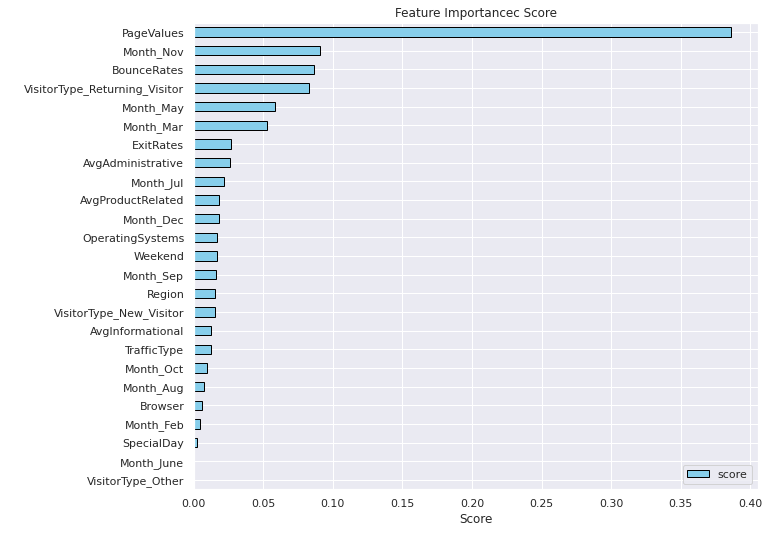

In [60]:
# Horizontal bar chart for feature Importance
feature_imp = pd.DataFrame({'feature':list(X.columns),'score':model.feature_importances_})
feature_imp.sort_values('score').plot(x='feature',y='score',kind='barh',color='skyblue',edgecolor='black',figsize=(9,8))

#plot formatting
plt.xlabel('Score')
plt.xticks()
plt.yticks()
plt.ylabel(' ')
plt.title('Feature Importancec Score')
plt.legend(loc="lower right")
plt.show();

In [61]:
## Finding Important Features then Removing from Dataframe
from sklearn import svm
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

list_one =[]
feature_ranking = SelectKBest(chi2, k=5)
fit = feature_ranking.fit(X, Y)

for i, (score, feature) in enumerate(zip(feature_ranking.scores_, X.columns)):
    list_one.append((score, feature))
    
dfObj = pd.DataFrame(list_one) 
dfObj.sort_values(by=[0], ascending = False)

X .drop(['Month_Aug','TrafficType','OperatingSystems','VisitorType_Other','Month_Jul'],axis=1,inplace=True)

,0,1
2,175126.808512,PageValues
23,10662.599140,AvgInformational
22,6829.412944,AvgAdministrative
24,1143.263922,AvgProductRelated
19,223.548231,Month_Nov
9,115.339482,VisitorType_New_Visitor
18,54.997108,Month_May
3,53.797094,SpecialDay
17,42.613274,Month_Mar
0,29.654336,BounceRates
